# clustering MOFA

In [1]:
here::i_am("rna_atac/clustering/02_clustering.ipynb")

source(here::here("settings.R"))
source(here::here("utils.R"))

suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ArchR))

BPPARAM <- BiocParallel::bpparam()
BPPARAM$workers = 21

# Multi core using future - built in to seurat
plan("multicore", workers = 16)
options(future.globals.maxSize = 50 * 1024 ^ 3) # for 50 Gb RAM

here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/code


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
      

In [2]:
args = list()
# MOFAsprintf('%s/results/rna_atac/combined_metadata.txt.gz',io$basedir)
args$metadata = file.path(io$basedir, 'results/rna_atac/combined_metadata.txt.gz')
args$MOFA = file.path(io$basedir, 'results/rna_atac/dimensionality_reduction/mofa/MOFA_factors.txt.gz')
args$MOFA_umap = file.path(io$basedir, 'results/rna_atac/dimensionality_reduction/mofa/MOFA_umap.txt.gz')

# RNA_sce
args$rna_sce = file.path(io$basedir, 'processed/rna/SingleCellExperiment.rds')

# outdir
args$outdir_clusters = file.path(io$basedir, 'results/rna_atac/clustering/')
dir.create(args$outdir_clusters, recursive=TRUE, showWarnings =FALSE)

In [3]:
###############
## Load data
###############

# Load meta
meta = fread(args$metadata)

# Load mofa 
mofa = fread(args$MOFA)
umap = fread(args$MOFA_umap)

# load sce
rna.sce <- load_SingleCellExperiment(args$rna_sce, normalise = TRUE, cells = meta$cell)

In [4]:
###############
## Prepare Seurat object
###############

# Add metadata to SCE
colData(rna.sce) = meta %>% as.data.frame() %>% tibble::column_to_rownames('cell') %>% DataFrame()

# Prepare mofa factors
mofa.mtx = mofa[match(meta$cell, cell)] %>% 
    as.data.frame(.) %>% 
    tibble::column_to_rownames('cell') %>%
    as.matrix()
# Prepare mofa umap
umap.mtx = umap[match(meta$cell, cell)] %>% 
    as.data.frame(.) %>% 
    tibble::column_to_rownames('cell') %>%
    as.matrix()

# Create Seurat objct
seurat = as.Seurat(rna.sce)
seurat[["mofa"]] <- CreateDimReducObject(embeddings = mofa.mtx, key = "mofa_", assay = DefaultAssay(seurat))
seurat[["umap"]] <- CreateDimReducObject(embeddings = umap.mtx, key = "umap_", assay = DefaultAssay(seurat))

In [5]:
###############
## Perform clustering
###############
seurat <- FindNeighbors(seurat, 
                        reduction='mofa',
                        k.param = 35)

seurat <- FindClusters(seurat, 
                       resolution = 1.5,  
                       n.start = 10,
                       n.iter = 10)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 31596
Number of edges: 1620924

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7961
Number of communities: 18
Elapsed time: 5 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


In [6]:
clusters = unique(seurat@meta.data$seurat_clusters)
colors = c(ArchR::ArchRPalettes$stallion, ArchR::ArchRPalettes$stallion2)[1:length(clusters)]
names(colors) = clusters

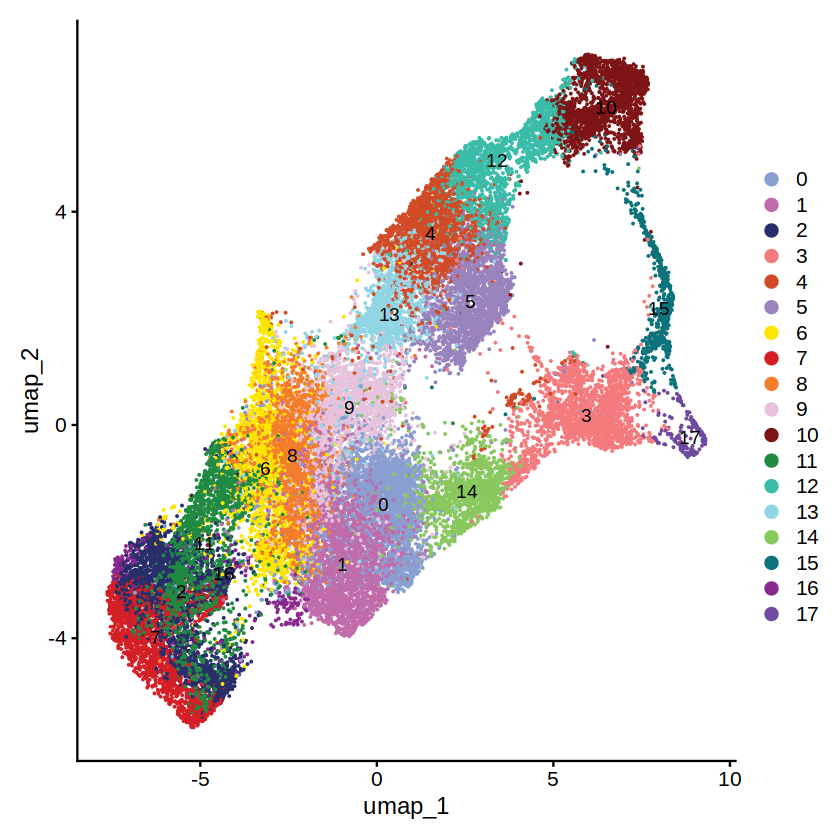

In [7]:
options(repr.plot.width=7, repr.plot.height=7)
DimPlot(seurat, reduction = "umap",  label = TRUE) + 
    scale_color_manual(values = colors)

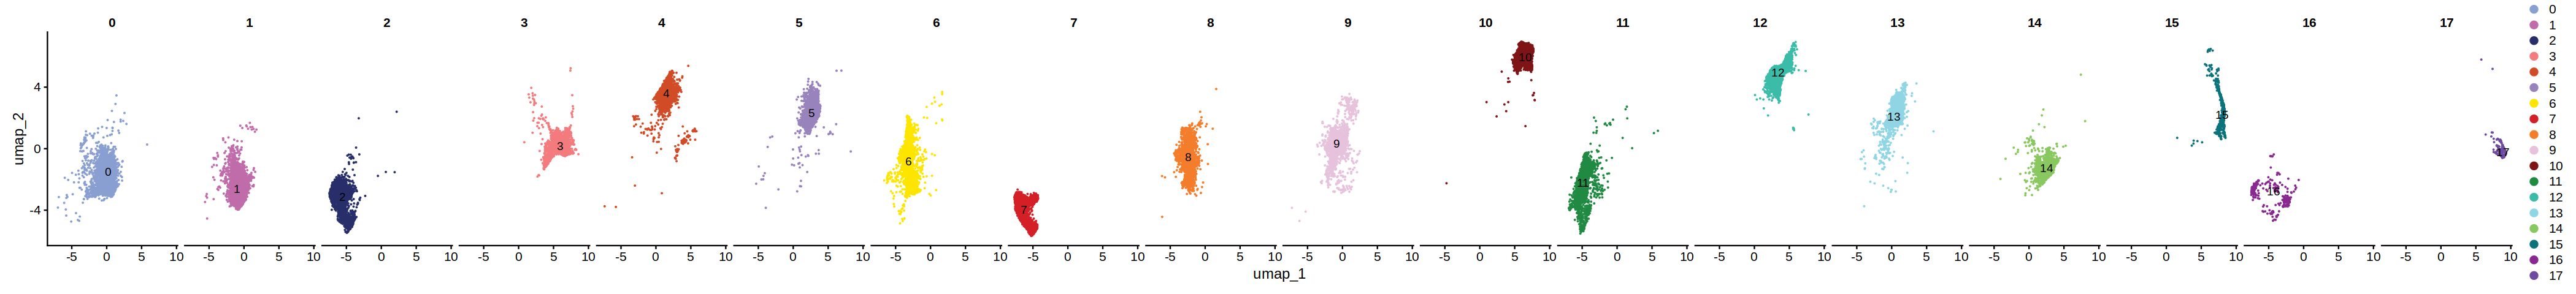

In [8]:
options(repr.plot.width=35, repr.plot.height=4)
DimPlot(seurat, reduction = "umap",  label = TRUE, split.by = 'seurat_clusters') + 
    scale_color_manual(values = colors)

In [19]:
meta$mofa_cluster = seurat@meta.data$seurat_clusters

In [23]:
fwrite(meta, sprintf('%s/metadata_mofa_clusters.txt.gz', args$outdir_clusters))

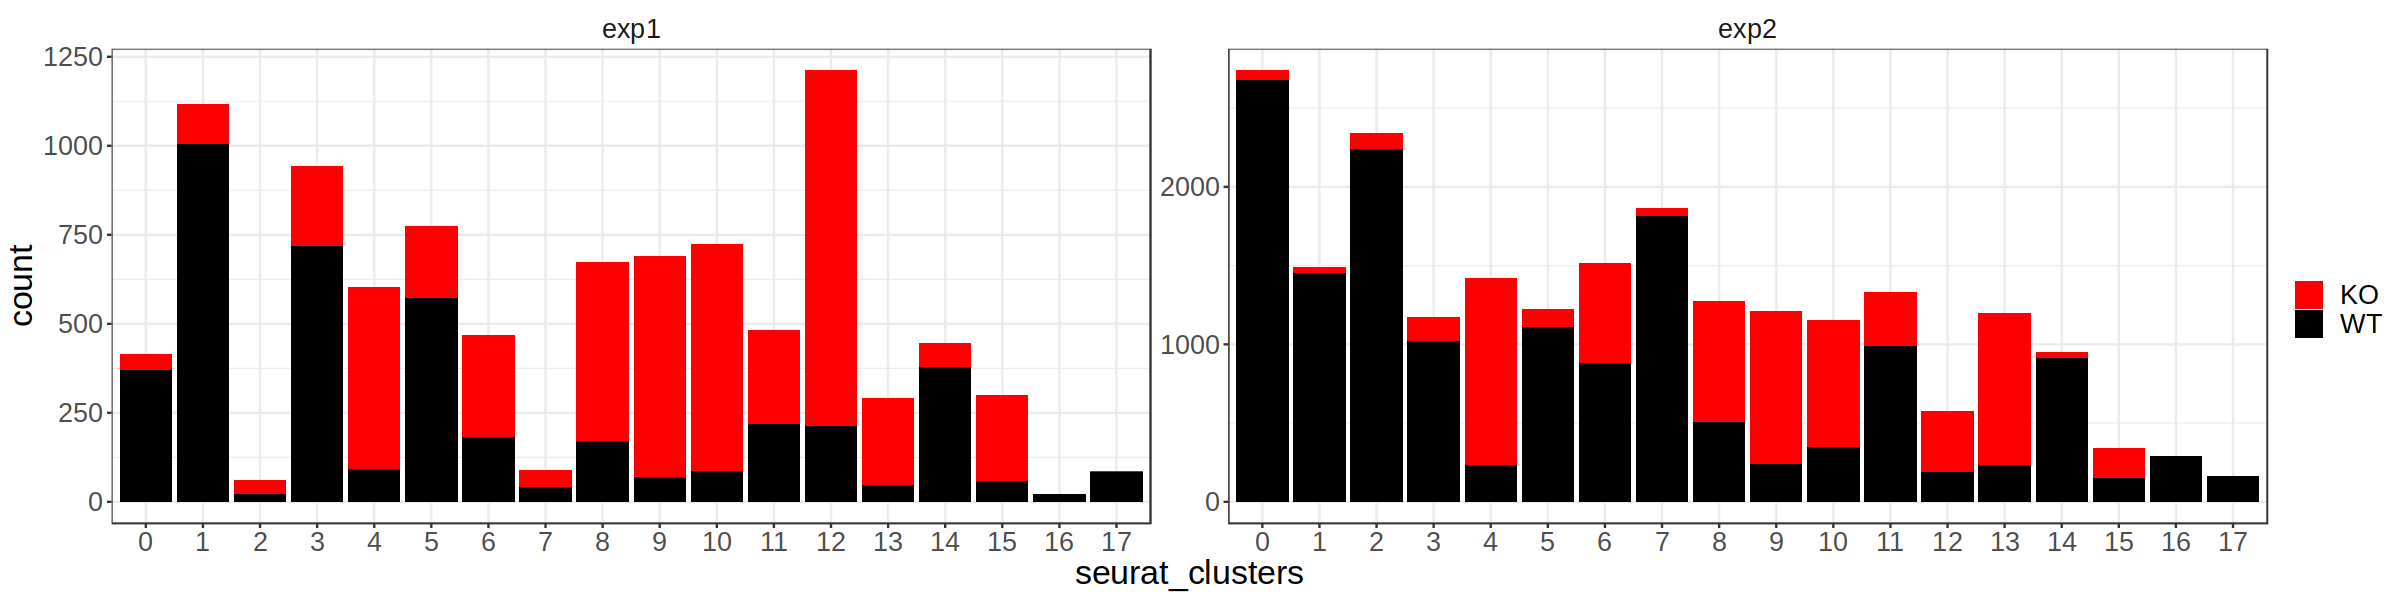

In [11]:
options(repr.plot.width=20, repr.plot.height=5)
ggplot(seurat@meta.data, aes(seurat_clusters, fill=genotype)) + 
    geom_bar() + 
    scale_fill_manual(values=opts$genotype.colors, name='') + 
    facet_wrap(~exp, scales = 'free_y') +
    theme_bw() +
    theme(strip.background = element_blank(),
         text=element_text(size=20, color='black'))

In [12]:
Freq = as.data.table(table(seurat@meta.data$seurat_clusters, seurat@meta.data$exp, seurat@meta.data$genotype)) %>% setnames(c('cluster','Experiment', 'genotype', 'Freq'))
fwrite(Freq, sprintf('%s/clusters_freq.csv', args$outdir_clusters))

In [13]:
meta_noD3 = as.data.table(seurat@meta.data)[day!='D3']
Freq = as.data.table(table(meta_noD3$seurat_clusters, meta_noD3$exp, meta_noD3$genotype)) %>% setnames(c('cluster','Experiment', 'genotype', 'Freq'))
fwrite(Freq, sprintf('%s/clusters_freq_noD3.csv', args$outdir_clusters))

In [14]:
Freq = as.data.table(table(meta_noD3$seurat_clusters, meta_noD3$genotype)) %>% setnames(c('cluster', 'genotype', 'Freq'))


In [15]:
Freq = dcast(Freq, cluster ~ genotype, value.var = c("Freq")) %>% 
    .[,FC := round(KO/WT, 2)]

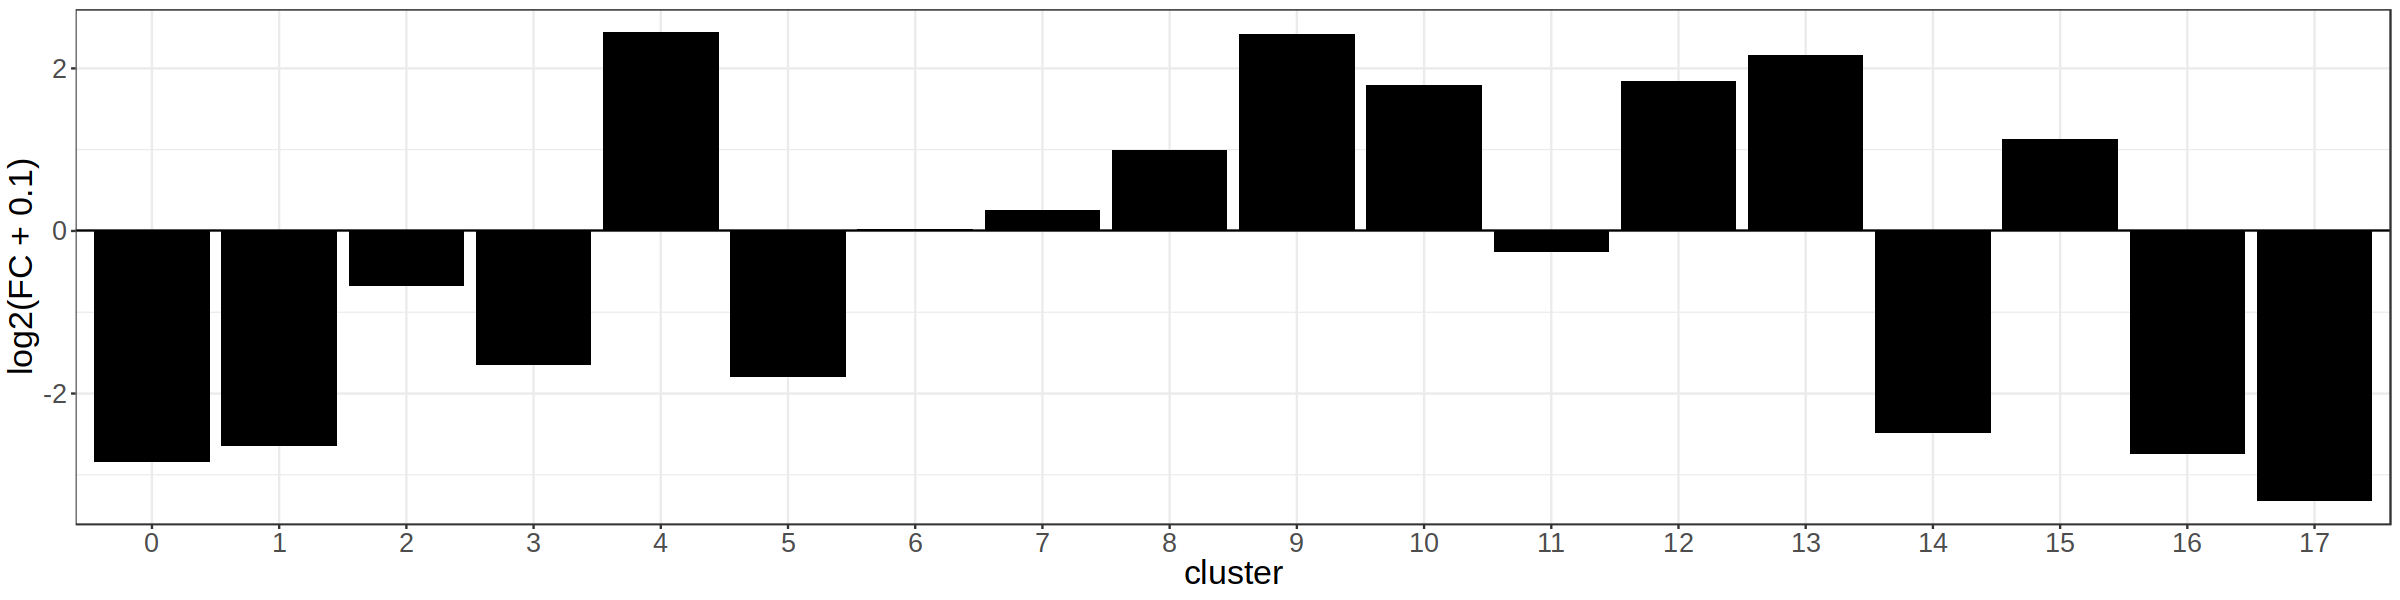

In [16]:
ggplot(Freq[,cluster:=factor(cluster, levels=0:length(unique(cluster)))], aes(cluster, log2(FC+1e-1))) + 
    geom_bar(stat='identity', fill='black') + 
    geom_hline(yintercept=0) + 
    theme_bw() +
    theme(strip.background = element_blank(),
         text=element_text(size=20, color='black'))

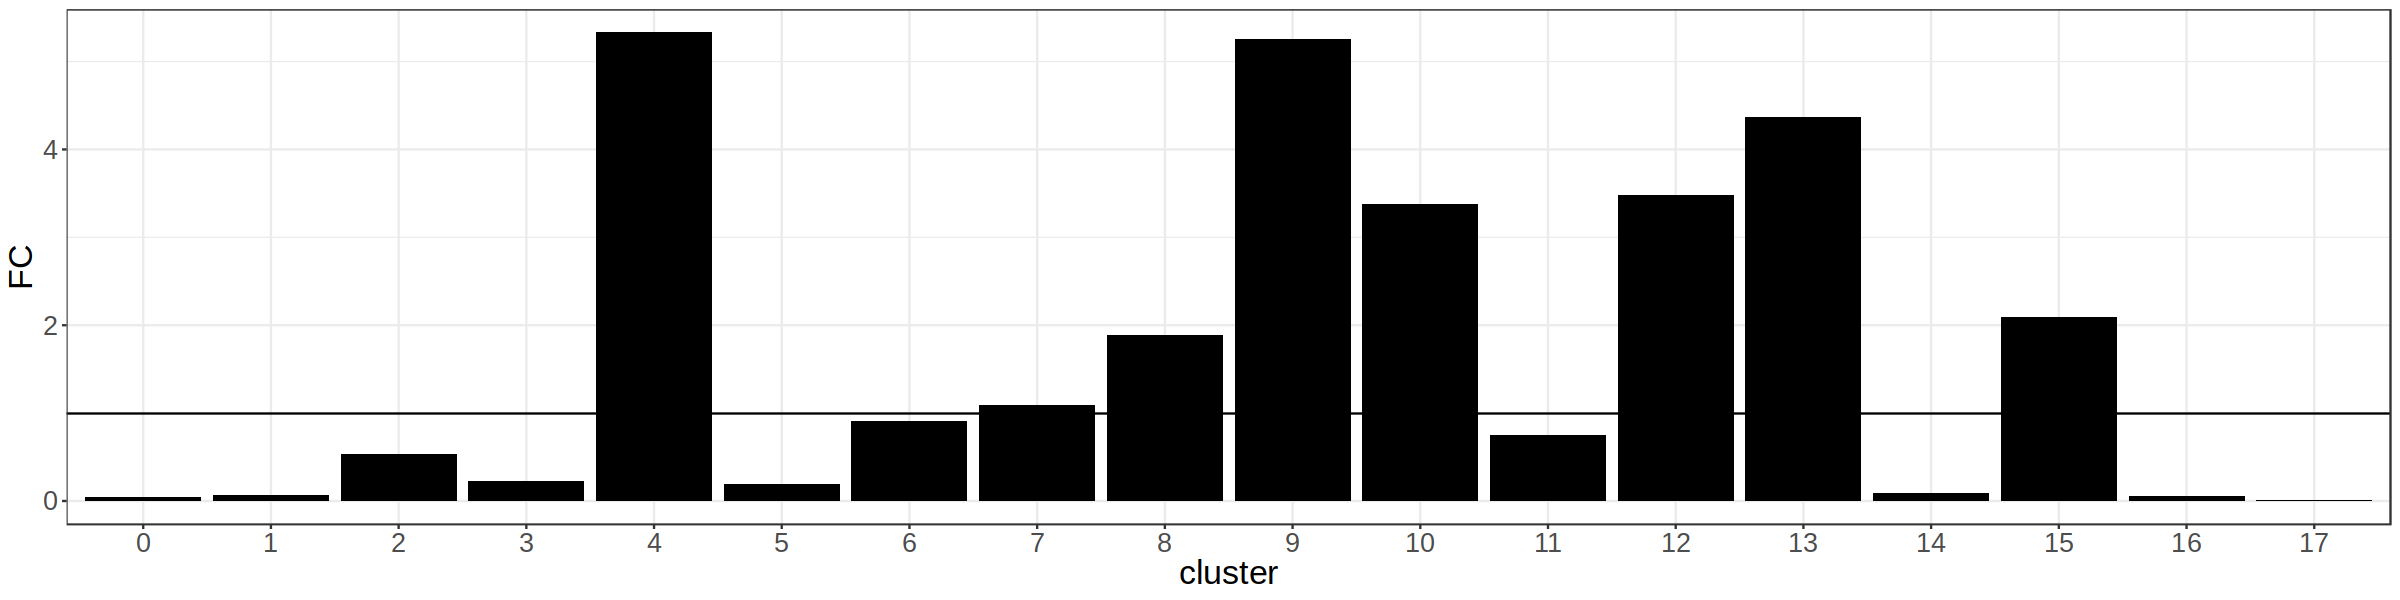

In [17]:
ggplot(Freq[,cluster:=factor(cluster, levels=0:length(unique(cluster)))], aes(cluster, FC)) + 
    geom_bar(stat='identity', fill='black') + 
    theme_bw() +
    geom_hline(yintercept=1) + 
    theme(strip.background = element_blank(),
         text=element_text(size=20, color='black'))